# Sistema di Rilevamento e Mappatura 3D con Stereo Vision e YOLO

## Obiettivo del Progetto
Il progetto si propone di sviluppare un sistema avanzato per la rilevazione degli oggetti in una scena ripresa da una macchina in movimento. Il sistema è in grado di:

1. **Calcolare la profondità**: Utilizzando un sistema stereo basato su SIFT e il feature matching.
2. **Rilevare oggetti**: Applicando il modello YOLO per identificare e localizzare gli oggetti nella scena.
3. **Determinare coordinate 3D**: Calcolando le posizioni tridimensionali degli oggetti rilevati.
4. **Visualizzare una mappa 3D**: Utilizzando Open3D per rappresentare graficamente gli oggetti nella scena.

---

Per semplificare l'acquisizione dei dati, sono stati utilizzati i dataset kitti, che hanno fornito:
- **Video stereo**: Catturati da una macchina in movimento.
- **Parametri della telecamera**: Inclusi i dati di calibrazione necessari per il calcolo della profondità.


## Calcolo della Profondità, Feature Matching e Stima del Movimento della Camera

### Calcolo della Profondità
Per calcolare la profondità della scena, le immagini stereo vengono passate a una funzione wrapper chiamata `stereo_depth`. All'interno di questa funzione, per ogni iterazione, viene costruita una **disparity map** a partire da una coppia di immagini stereo.  
La disparità è calcolata utilizzando la funzione `StereoSGBM` di OpenCV, un'implementazione dell'algoritmo di Hirschmüller. Una **disparity map** è mostrata di seguito:  

![Immagine non disponibile](references/disparity_map.png)


Una volta ottenuta la mappa di disparità, la profondità della scena viene calcolata utilizzando la formula:  

### $z = \frac{f \times b}{d}$

Dove:  
- **z**  è la profondità,  
- **f** è la lunghezza focale della camera,  
- **b** è la baseline (distanza tra le due telecamere stereo),  
- **d** è la disparità.  

Questa formula ci consente di convertire la disparità in una **depth map**, che rappresenta le distanze degli oggetti nella scena.  

![Immagine non disponibile](references/depth_map.png)

---

### Estrazione di Feature e Matching
Successivamente, le immagini catturate dalla camera sinistra vengono processate per estrarre **feature**, quindi punti chiave e i loro descrittori utilizzando SIFT (Scale-Invariant Feature Transform) o ORB. Questi descrittori vengono passati a una funzione per calcolare i **matching** tra due frame consecutivi della sequenza video.  

Per il matching viene utilizzata la funzione **Brute-Force Matching** con norma $L2$ (distanza euclidea tra due descrittori) di OpenCV. Questa tecnica produce un gran numero di punti corrispondenti, ma non tutti sono corretti. Pertanto, viene applicata una soglia per filtrare i match deboli.  

![Immagine non disponibile](references/matches.png)

---

### Calcolo delle Coordinate 3D
Una volta ottenuto un numero sufficiente di punti corrispondenti (match), le coordinate 3D vengono calcolate utilizzando:  
1. **punti chiave** rilevati.  
2. **Matching** validi.  
3. Parametri intrinseci della camera.

La profondità **z** dei punti 3D viene recuperata dai match, mentre le coordinate **x** e **y** sono calcolate utilizzando le formule:  

### $x = z \cdot \frac{(u - c_x)}{f_x}$
  

### $y = z \cdot \frac{(v - c_y)}{f_y}$
  

Dove:  
- **$u,v$**: coordinate pixel del punto.  
- **$f_x, f_y$**: distanza focale lungo gli assi **x** e **y**.  
- **$c_x, c_y$**: centro ottico dell'immagine.  

Le distanze focali e il centro ottico sono ottenuti dalla **matrice intrinseca** della camera:

\begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1 
\end{bmatrix}

---

### Stima del Movimento della Camera
Dai punti 3D calcolati, viene stimato il movimento della camera tra frame consecutivi usando l'algoritmo **pnp** (perspective n-point). Il suo obiettivo è calcolare la matrice di rotazione R e il vettore di traslazione t, che descrivono la posa della telecamera. Per farlo, l'algoritmo utilizza un insieme di n corrispondenze tra punti 3D noti e le loro proiezioni 2D nel piano immagine. 

Per migliorare l'accuratezza, viene applicato l'algoritmo **Ransac** per eliminare valori anomali (outlier) dai punti 3D. Questo passaggio è essenziale per ottenere una stima affidabile della posizione e orientamento della camera.

$\begin{bmatrix}
u \\
v \\
1 
\end{bmatrix} = K \cdot \begin{bmatrix} R & t \end{bmatrix} \cdot \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix} $  


In [1]:

import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import random
from ultralytics import YOLO
import open3d as o3d
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Descrizione della Classe `DataLoader`

La classe DataLoader è progettata per caricare e gestire le immagini stereo provenienti da un dataset, insieme ai parametri di calibrazione della telecamera.

Quando viene inizializzata, la classe riceve come parametro un percorso (path) che punta alla directory contenente le immagini e i file di calibrazione.

Le immagini della telecamera sinistra e destra vengono memorizzate in due liste separate, left_images e right_images, e la lunghezza di queste liste viene utilizzata per determinare il numero totale di coppie di immagini, rappresentato dalla variabile frames. 

Inoltre, la classe carica i parametri di calibrazione necessari per l'elaborazione delle immagini. Viene letto il file calib_cam_to_cam.txt, che contiene le matrici di proiezione per le telecamere sinistra e destra. Le matrici di calibrazione, P0 e P1, vengono quindi salvate come variabili della classe per essere utilizzate in seguito nel calcolo della profondità.


In [2]:
class DataLoader(object):
    def __init__(self, path):
        self.main_path = path
        self.left_camera_images = sorted(os.listdir(os.path.join(self.main_path, "image_02/data")))
        self.right_camera_images = sorted(os.listdir(os.path.join(self.main_path, "image_03/data")))
        self.frames = len(self.left_camera_images)

        calibration = pd.read_csv(os.path.join(self.main_path, "calib_cam_to_cam.txt"), delimiter=' ', header=None, index_col=0)
        #projection matrix
        self.P0 = np.array(calibration.loc['P_rect_02:'], dtype=np.float32).reshape((3,4))
        self.P1 = np.array(calibration.loc['P_rect_03:'], dtype=np.float32).reshape((3,4))

        #image loader
        self.left_images = []
        self.right_images = []

        for i, left in enumerate(self.left_camera_images):
            right = self.right_camera_images[i]
            self.left_images.append(cv2.imread((os.path.join(self.main_path, "image_02/data/")) + left))
            self.right_images.append(cv2.imread((os.path.join(self.main_path, "image_03/data/")) + right))
        
        self.first_image_left = self.left_images[0]
        self.first_image_right = self.right_images[0]
        self.second_image_left = self.left_images[1]
        self.second_image_right = self.right_images[1]

        self.image_height = self.left_images[0].shape[0]
        self.image_width = self.left_images[0].shape[1]
        

## Sezione Utils: Funzioni di Supporto

Questa sezione contiene una raccolta di funzioni utili e modulari che vengono utilizzate in varie parti del progetto per migliorare la leggibilità e la modularità del codice. 
Di seguito viene fornita una panoramica delle principali funzionalità implementate:

### Caricamento della Configurazione
Inizialmente vengono caricati dei parametri da un file YAML **(initial_config.yaml)** per rendere il codice facilmente configurabile e adattabile. Questi parametri vengono utilizzati nelle funzioni per definire aspetti come la profondità massima, il nome del rilevatore di feature (SIFT o ORB) e altre impostazioni.

### disparity_mapping
La funzione **disparity_mapping** calcola la mappa di disparità tra due immagini stereo utilizzando l'algoritmo StereoSGBM di OpenCV.

### decomposition
La funzione **decomposition** estrae la matrice intrinseca, la matrice di rotazione e il vettore di traslazione da una matrice di proiezione, rendendo queste informazioni accessibili per calcoli futuri.

### depth_mapping
La funzione **depth_mapping** calcola la profondità a partire dalla mappa di disparità. Utilizza la lunghezza focale e il baseline della telecamera per convertire i pixel della disparità in coordinate di profondità reali.

### feature_extractor e feature_matching
Le funzioni **feature_extractor** e **feature_matching** consentono di rilevare punti caratteristici in un'immagine utilizzando algoritmi come SIFT o ORB e di associare tali punti tra immagini sequenziali. Questi passaggi sono cruciali per il tracking e il motion estimation.

### visualize_matches
La funzione **visualize_matches** permette di visualizzare i punti corrispondenti tra due immagini, semplificando il debugging e la comprensione del processo di matching.

### motion_estimation
La funzione **motion_estimation** calcola la stima del movimento della telecamera tra due fotogrammi sequenziali. Utilizza i punti 3D derivati dalla mappa di profondità e applica l'algoritmo RANSAC per rimuovere gli outlier, migliorando l'accuratezza della stima.

### pointCleaning
La funzione **pointCleaning** viene utilizzata per filtrare i punti 3D visualizzati nella mappa 3D degli oggetti rilevati durante il video. Utilizza un KD-Tree per identificare e rimuovere punti rumorosi, al fine di avere una visualizzazione dei dati più pulita e accurata.


### get_next_filename
La funzione **get_next_filename** genera in modo incrementale nomi di file unici all'interno di una cartella specificata.


In [3]:
with open("./initial_config.yaml", "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as error:
        print(error)

rgb_value = config['parameters']['rgb']
rectified_value = config['parameters']['rectified']
detector_name = config['parameters']['detector']
max_depth_value = config['parameters']['max_depth']

##stereo depth estimation

def disparity_mapping(left_image, right_image, rgb=rgb_value):
    if rgb:
        num_channels = 3
    else:
        num_channels = 1

    min_disp = 0
    nDispFactor = 10
    num_disparities = 16*nDispFactor-min_disp
    block_size = 7

    matcher = cv2.StereoSGBM_create(numDisparities = num_disparities, 
                                    minDisparity = min_disp, 
                                    blockSize = block_size, 
                                    P1=8 * num_channels * block_size ** 2,
                                    P2=32 * num_channels * block_size ** 2,
                                    mode = cv2.STEREO_SGBM_MODE_SGBM_3WAY)
    if rgb:
        left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
        right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)
    
    left_image_disparity_map = matcher.compute(left_image, right_image).astype(np.float32)/16.0

    return left_image_disparity_map

def decomposition(p):

    intrinsic_matrix, rotation_matrix, translation_vector, _, _, _, _ = cv2.decomposeProjectionMatrix(p)

    translation_vector = (translation_vector / translation_vector[3])[:3]

    return intrinsic_matrix, rotation_matrix, translation_vector

def depth_mapping(left_disparity_map, left_intrinsic, left_translation, right_translation, rectified=rectified_value):

    focal_length = left_intrinsic[0][0]

    if rectified:
        baseline = right_translation[0] - left_translation[0]
    else:
        baseline = left_translation[0] - right_translation[0]

    left_disparity_map[left_disparity_map == 0.0] = 0.1
    left_disparity_map[left_disparity_map == -1.0] = 0.1

    depth_map = np.ones(left_disparity_map.shape)
    depth_map = (focal_length * baseline) / left_disparity_map

    return depth_map

def stereo_depth(left_image, right_image, P0, P1, rgb=rgb_value):

    disp_map = disparity_mapping(left_image, right_image, rgb=rgb)
    

    l_intrinsic, l_rotation, l_translation = decomposition(P0)
    r_intrinsic, r_rotation, r_translation = decomposition(P1)

    depth = depth_mapping(disp_map, l_intrinsic, l_translation, r_translation)

    return depth

##stereo depth estimation


##feature extraction and matching

def feature_extractor(image, detector=detector_name,mask=None):

    if detector == 'sift':
        create_detector = cv2.SIFT_create()
    elif detector == 'orb':
        create_detector = cv2.ORB_create()

    keypoints, descriptors = create_detector.detectAndCompute(image, mask)

    return keypoints, descriptors

def feature_matching(first_descriptor, second_descriptor, detector=detector_name, k=2, distance_threshold=1.0):

    if detector == 'sift':
        feature_matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck = False)
    elif detector == 'orb':
        feature_matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck = False)
    matches = feature_matcher.knnMatch(first_descriptor, second_descriptor, k=k)
    filtered_matches = []
    for match1, match2 in matches:
        if match1.distance <= distance_threshold * match2.distance:
            filtered_matches.append(match1)

    return filtered_matches

def visualize_matches(first_image, second_image, keypoint_one, keypoint_two, matches):
    show_matches = cv2.drawMatches(first_image, keypoint_one, second_image, keypoint_two, matches, None, flags = 2)
    plt.figure(figsize=(15, 5), dpi=100)
    plt.imshow(show_matches)
    plt.show()

##feature extraction and matching

##motion estimation

def motion_estimation(matches, firstImage_keypoints, secondImage_keypoints, intrinsic_matrix, depth, max_depth=max_depth_value):
    """
    Estimating motion of the left camera from sequential imgaes 

    """
    rotation_matrix = np.eye(3)
    translation_vector = np.zeros((3, 1))

    # Only considering keypoints that are matched for two sequential frames
    image1_points = np.float32(
        [firstImage_keypoints[m.queryIdx].pt for m in matches])
    image2_points = np.float32(
        [secondImage_keypoints[m.trainIdx].pt for m in matches])

    cx = intrinsic_matrix[0, 2]
    cy = intrinsic_matrix[1, 2]
    fx = intrinsic_matrix[0, 0]
    fy = intrinsic_matrix[1, 1]

    points_3D = np.zeros((0, 3))
    outliers = []

    # Extract depth information to build 3D positions
    for indices, (u, v) in enumerate(image1_points):
        z = depth[int(v), int(u)]

        # We will not consider depth greater than max_depth
        if z > max_depth:
            outliers.append(indices)
            continue

        # Using z we can find the x,y points in 3D coordinate using the formula
        x = z*(u-cx)/fx
        y = z*(v-cy)/fy

        # Stacking all the 3D (x,y,z) points
        points_3D = np.vstack([points_3D, np.array([x, y, z])])

    # Deleting the false depth points
    image1_points = np.delete(image1_points, outliers, 0)
    image2_points = np.delete(image2_points, outliers, 0)

    # Apply Ransac Algorithm to remove outliers
    _, rvec, translation_vector, _ = cv2.solvePnPRansac(
        points_3D, image2_points, intrinsic_matrix, None)

    rotation_matrix = cv2.Rodrigues(rvec)[0]

    return rotation_matrix, translation_vector, image1_points, image2_points

def pointCleaning(points, threshold):    
    kdtree = cKDTree(points)
    cleaned_points = []

    for i, point in enumerate(points):
        neighbour = kdtree.query(point, k=100, distance_upper_bound=threshold)

        distance = neighbour[0]
        idxs = neighbour[1]

        distance = distance[distance < threshold]

        if len(distance) > 50:
            cleaned_points.append(point)
    return cleaned_points

def get_next_filename(folder, base_name, ext):
    index = 1
    while True:
        filename = base_name + str(index) + ext
        filepath = os.path.join(folder, filename)
        if not os.path.exists(filepath):
            return filepath
        index += 1


## Elaborazione con YOLOv11

Questa sezione si occupa dell'elaborazione dei frame video utilizzando il modello di rilevamento YOLOv11. L'obiettivo principale è rilevare oggetti nella scena, restituendo informazioni dettagliate su ciascun oggetto rilevato.

![Immagine non disponibile](references/yolo_results.png)

L'opzione **persist=True**, all'interno di yolo_model.track, consente di mantenere le informazioni sul tracciamento tra i frame.

Infine viene restituita una lista contenente le informazioni sugli oggetti rilevati e un'altra lista contenente gli id di questi.


In [4]:
yolo_model = YOLO('yolo11n.pt') 

In [5]:
def yolo_elaboration(frame):
    detection_info = []
    detection_id = []

    yolo_results = yolo_model.track(frame, persist=True)

    if not yolo_results[0]:
        return detection_info, detection_id 
    

    #risultati del rilevamento
    detection = yolo_results[0].boxes.xyxy #coordinate della bounding box
    confidences = yolo_results[0].boxes.conf #confidenza della rilevazione
    class_ids = yolo_results[0].boxes.cls #ID delle classi di appartenenza dell'oggetto
    obj_ids = yolo_results[0].boxes.id #ID dell'oggetto
    
    #ciclo di gestione dei risultati 
    
    for i, (box, conf, cls_id, obj_id) in enumerate(zip(detection, confidences, class_ids, obj_ids)):
        x1, y1, x2, y2 = map(int, box) #estrazione delle le coordinate della bounding box

        label = f"{yolo_model.names[int(cls_id)]} ({conf:.2f})" 

        detection_info.append({
            'id': obj_id,
            'label': label,
            'confidence': conf,
            'class': cls_id,
            'x1': x1,
            'x2': x2,
            'y1': y1,
            'y2': y2
        })
        detection_id.append(obj_id)
    #annotated_frame = yolo_results[0].plot()
    #plt.title("yolo")
    #plt.imshow(annotated_frame)
    return detection_info, detection_id

# Elaborazione di Oggetti e Coordinate 3D

Questa sezione contiene due funzioni principali per il calcolo  delle coordinate 3D degli oggetti rilevati precedentemente.

---

In particolare la funzione _elaboration calcola le coordinate 3D degli oggetti rilevati all'interno di una bounding box e le trasforma nel sistema di riferimento globale.

### Funzionamento

Vengono estratti i parametri della telecamera (cx, cy, fx, fy) dalla matrice intrinseca.
   
Per ogni pixel campionato (20% dei pixel totali per alleggerire i calcoli):
   - La profondità z viene recuperata dalla mappa di profondità (depth_map).
   - Le coordinate 3D reali x,y vengono calcolate usando le seguenti formule:

        #### $x_{real} = \frac{(x - c_x) \cdot depth}{f_x}$;
        #### $y_{real} = \frac{(y - c_y) \cdot depth}{f_y}$.

Le coordinate 3D vengono trasformate nel sistema di riferimento globale utilizzando la homogenous matrix e aggiunte alla lista object_data.

### Output
- Restituisce:
  - object_data: coordinate 3D dell'oggetto.
  - label: etichetta dell'oggetto.
  - confidence: livello di confidenza del rilevamento.

---

La funzione elaboration aggiorna i dati degli oggetti rilevati combinando i rilevamenti attuali con quelli passati.

### Funzionamento

Inizialmente viene fatto un controllo su current_detection, se non ci sono nuovi rilevamenti, la funzione restituisce old_detection.

Poi per ogni oggetto nei rilevamenti attuali:
   - Se l'oggetto è già stato rilevato (obj_id in old_detection_id), le coordinate 3D vengono aggiornate combinando i dati attuali e passati.
   - Se l'oggetto non è stato rilevato in precedenza, un nuovo oggetto viene creato con le sue coordinate 3D calcolate e viene aggiunto a old_detection.

### Output
- Restituisce old_detection aggiornato, contenente:
  - ID dell'oggetto
  - Classe dell'oggetto.
  - label
  - Livelli di confidenza.
  - Coordinate 3D.


In [6]:
def _elaboration(object, object_data, depth_map, transformation_matrix, intrinsic_matrix):
    cx = intrinsic_matrix[0, 2]
    cy = intrinsic_matrix[1, 2]
    fx = intrinsic_matrix[0, 0]
    fy = intrinsic_matrix[1, 1]
    label = object['label']
    confidence = object['confidence']
    x1 = object['x1']
    x2 = object['x2']
    y1 = object['y1']
    y2 = object['y2']
    #if confidence < 0.20:
        #continue
    for y in range(y1, y2):
        for x in range(x1, x2):
            #campiono il 20% dei pixel all'interno della bounding box
            if random.random() > 0.20:
                continue
            depth = depth_map[y,x]
            if depth > 100:
                continue
            real_x = ((x - cx) * depth)/fx
            real_y = ((y - cy) * depth)/fy
            obj_coords = np.array([real_x, real_y, depth, 1])
            world_obj_coords = transformation_matrix.dot(obj_coords)
            object_data.append(world_obj_coords)
    return object_data, label, confidence

In [7]:
def elaboration(depth_map, current_detection, old_detection, old_detection_id, intrinsic_matrix, transformation_matrix):
    if not current_detection:
        return old_detection
    detection_info = current_detection
    
    for object in detection_info:
        obj_id = object['id'] 
        obj_class = object['class']
        #se l'oggetto rilevato e' stato gia scansionato precedentemente, ne miglioro la posizione aggiungendo le coordinate dei pixel della scansione nuova
        if obj_id in old_detection_id:
            
            object_data = []
            for obj in old_detection:
                if obj['id'] == obj_id:
                    object_data = obj['3dcoord']
                    break
            object_data, label, confidence = _elaboration(object, object_data, depth_map, transformation_matrix, intrinsic_matrix)
            
            for i, obj in enumerate(old_detection):
                if obj['id'] == obj_id:
                    old_detection[i] = {'id': obj_id,
                                        'class': obj_class,
                                        'label': label,
                                        'confidence': confidence,
                                        '3dcoord': object_data}
            continue
        
        #se l'oggetto scansionato non era stato scansionato precedentemente, aggiungo un nuovo elemento nella lista old_detection che contiene varie informazioni tra cui l'id e le coordinate dei pixel del nuovo oggetto
        object_data = []
        object_data, label, confidence = _elaboration(object, object_data, depth_map, transformation_matrix, intrinsic_matrix)
        old_detection.append({
            'id' : obj_id,
            'class': obj_class,
            'label' : label,
            'confidence' : confidence,
            '3dcoord' : object_data
        })
    return old_detection


## threedMapConversion

La funzione `threedMapConversion` ha il compito di inserire le coordinate 3D calcolate in una mappa tridimensionale visualizzabile. Utilizza il modulo Open3D per creare una point cloud rappresentante la scena rilevata.

### Funzionamento

   Per ciascun oggetto in detection_info, vengono estratte le coordinate tridimensionali dai dati disponibili, escludendo il quarto elemento (che rappresenta un punto omogeneo).

   Se la lista è vuota, significa che non sono stati scansionati oggetti nella scena. In tal caso, viene stampato un messaggio di avviso e la funzione termina.
   Successivamente la funzione pointCleaning fa una pulizia dei punti al fine di rendere la visualizzazione piu' comprensibile

   Le coordinate della telecamera vengono aggiunte ai punti già raccolti per includerle nella rappresentazione finale cosicche' sia visibile lo spostamento che la macchina ha compiuto.
   
   I punti nella lista poi vengono usati per creare un oggetto PointCloud che rappresenta una nuvola di punti, che viene salvata come file .ply   

![Immagine non disponibile](references/point_cloud2.png)

---

![Immagine non disponibile](references/point_cloud_top.png)




In [8]:
def threedMapConversion(detection_info, camera_coordinates,):
    points = []
    for object in detection_info:
        threedcoords = [coord[:3] for coord in object['3dcoord']]
        points.extend(threedcoords)
    if not points:
        print("Non sono stati scansionati oggetti")
        return
    points = pointCleaning(points, 0.2)
    points.extend(camera_coordinates)
    points = np.array(points)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    o3d.visualization.draw_geometries([pcd])

    output_path = get_next_filename("renders", "output", ".ply")
    print("Il file .ply e' stato salvato in ", output_path)
    o3d.io.write_point_cloud(output_path, pcd)


In [9]:
pcd = o3d.io.read_point_cloud("renders/output2.ply")
o3d.visualization.draw_geometries([pcd])


La seguente funzione contiene un ciclo per ogni frame del video in cui vengono eseguiti diversi compiti:

### Calcolo della traiettoria della telecamera

Viene calcolata la depth map a partire dalla disparity map come spiegato in precedenza, successivamente viene stimato il movimento della telecamera per frame sequenziali e aggiornata la homogenous matrix (matrice contenente la rotazione e la traslazione della telecamera).

### Rilevamento di oggetti nella scena

Tramite YOLO (You only look once) viene fatta una scansione degli oggetti presenti nel frame, i dati raccolti vengono passati nella funzione elaboration che conserva le coordinate 3d dei punti nella bounding box dell'oggetto

---

Alla fine del ciclo, le informazioni su tutti gli oggetti scansionati sono usate per generare una mappa 3d che verra' salvata nella cartella renders in formato .ply


In [10]:
with open("./initial_config.yaml", "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as error:
        print(error)

detector_name = config['parameters']['detector']
subset = config['parameters']['subset']
threshold = config['parameters']['distance_threshold']

def odometry(data_handler, detector = detector_name, mask = None, subset = subset, plot = True):

    if subset is not None:
        num_frames = subset
    else:
        num_frames = data_handler.frames

    # Create a homogeneous matrix
    homo_matrix = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = homo_matrix[:3, :]
    camera_coordinates = []

    # From projection matrix retrieve the left camera's intrinsic matrix
    left_intrinsic_matrix, _, _ = decomposition(data_handler.P0)

    #yolo
    detection = []
    detection_id = []

    # Loop to iterate all the frames
    for i in range(num_frames - 1):

        image_left = data_handler.left_images[i]
        image_right = data_handler.right_images[i]
        next_image = data_handler.left_images[i + 1]

        # Estimating the depth of an image
        depth = stereo_depth(image_left, image_right, P0=data_handler.P0, P1=data_handler.P1)
        #plt.title("Stereo Depth Mapping")
        #plt.figure(figsize=(12,6))
        #plt.imshow(depth)
        #print(depth)
        
        # Keypoints and Descriptors of two sequential images of the left camera
        keypoint_left_first, descriptor_left_first = feature_extractor(image_left, detector, mask)
        keypoint_left_next, descriptor_left_next = feature_extractor(next_image, detector, mask)

        # Use feature (e.g. SIFT or ORB) detector to match features
        matches = feature_matching(descriptor_left_first, descriptor_left_next, detector=detector, distance_threshold=threshold)

        # Estimate motion between sequential images of the left camera
        rotation_matrix, translation_vector, _, _ = motion_estimation(matches, keypoint_left_first, keypoint_left_next, left_intrinsic_matrix, depth)

        # Initialise a homogeneous matrix (4X4)
        Transformation_matrix = np.eye(4)

        # Build the Transformation matrix using rotation matrix and translation vector from motion estimation function
        Transformation_matrix[:3, :3] = rotation_matrix
        Transformation_matrix[:3, 3] = translation_vector.T

        # Transformation wrt. world coordinate system
        homo_matrix = homo_matrix.dot(np.linalg.inv(Transformation_matrix))

        # Append the pose of camera in the trajectory array
        trajectory[i+1, :, :] = homo_matrix[:3, :]
        camera_coordinates.append((trajectory[i,0,3], trajectory[i,1,3], trajectory[i,2,3]))

        #yolo
        new_detection, new_detection_id = yolo_elaboration(image_left)

        #elaboration
        detection = elaboration(depth, new_detection, detection, detection_id, left_intrinsic_matrix, homo_matrix)

        if new_detection_id is not None:
            detection_id.extend(new_detection_id)
        if i % 10 == 0:
            print(f'{i} frames sono stati elaborati')

        if i == num_frames - 2:
            print('Tutti i frames sono stati elaborati')
            break
    threedMapConversion(detection, camera_coordinates)
    return trajectory


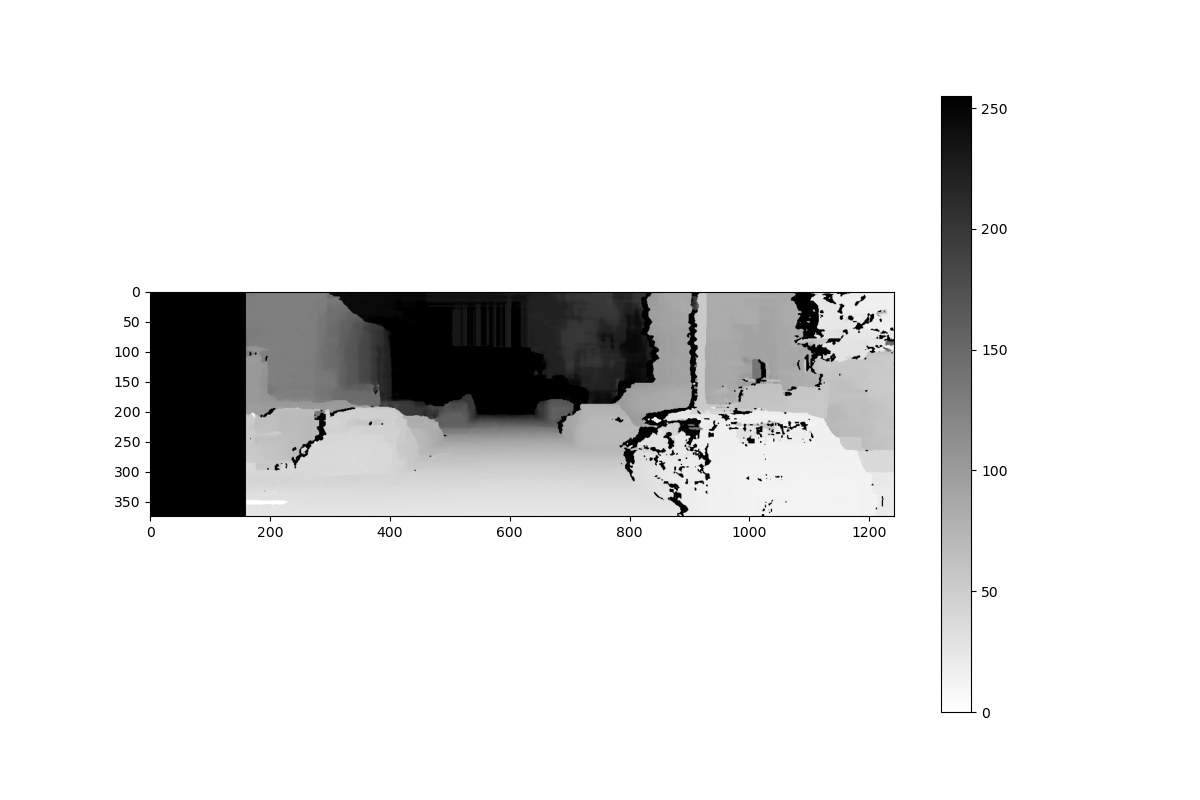

In [4]:
%matplotlib widget

path1 = "videoreferences/2011_09_26_drive_0035_sync/image_00/data/0000000000.png"
path2 = "videoreferences/2011_09_26_drive_0035_sync/image_01/data/0000000000.png"
data_handler = DataLoader("videoreferences/2011_09_26_drive_0035_sync")
depth = stereo_depth(cv2.imread(path1), cv2.imread(path2), data_handler.P0, data_handler.P1, rgb_value)
normalized_depth = depth
normalized_depth[normalized_depth > 40] = 40
normalized_depth = (normalized_depth - np.min(normalized_depth)) / (np.max(normalized_depth) - np.min(normalized_depth)) * 255
#normalized_depth = normalized_depth.astype(np.uint8)

plt.figure(figsize=(12,8))
plt.imshow(normalized_depth, "gray_r")
plt.colorbar()

plt.show()


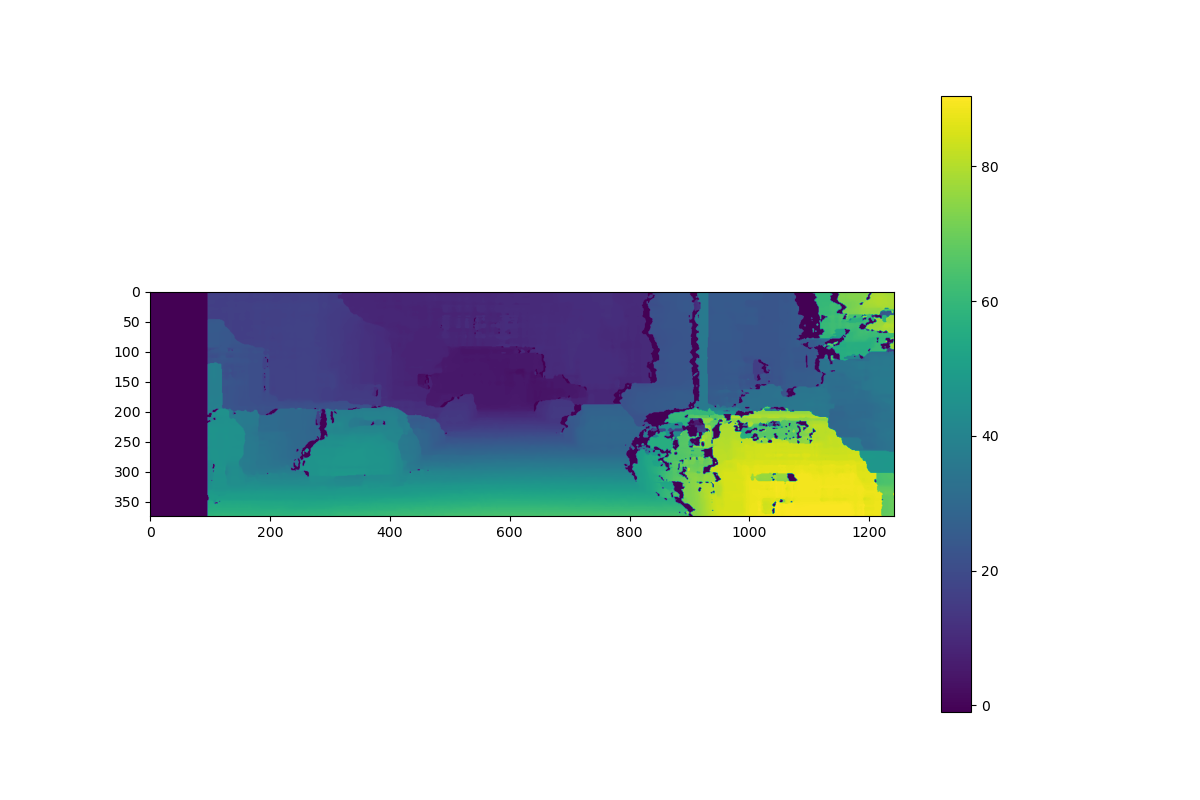


0: 224x640 3 persons, 8 cars, 40.0ms
Speed: 2.5ms preprocess, 40.0ms inference, 54.5ms postprocess per image at shape (1, 3, 224, 640)
0 frames sono stati elaborati


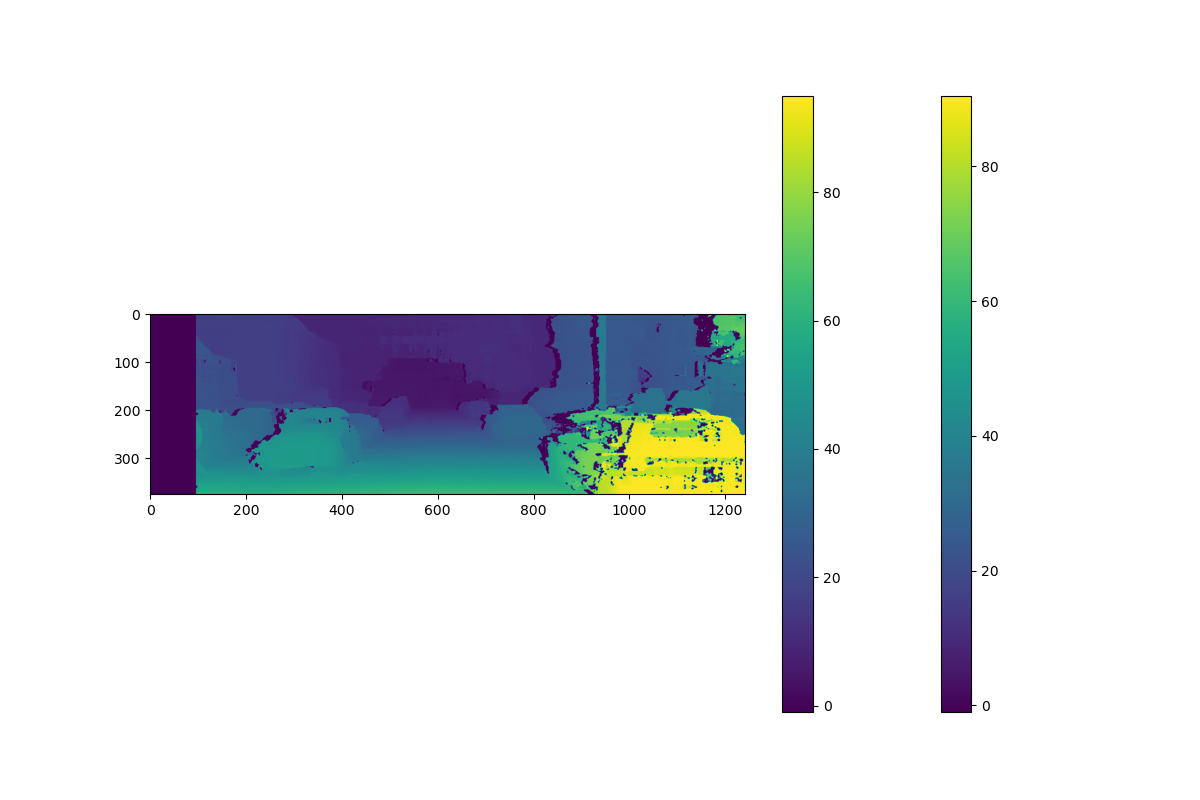


0: 224x640 2 persons, 6 cars, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)


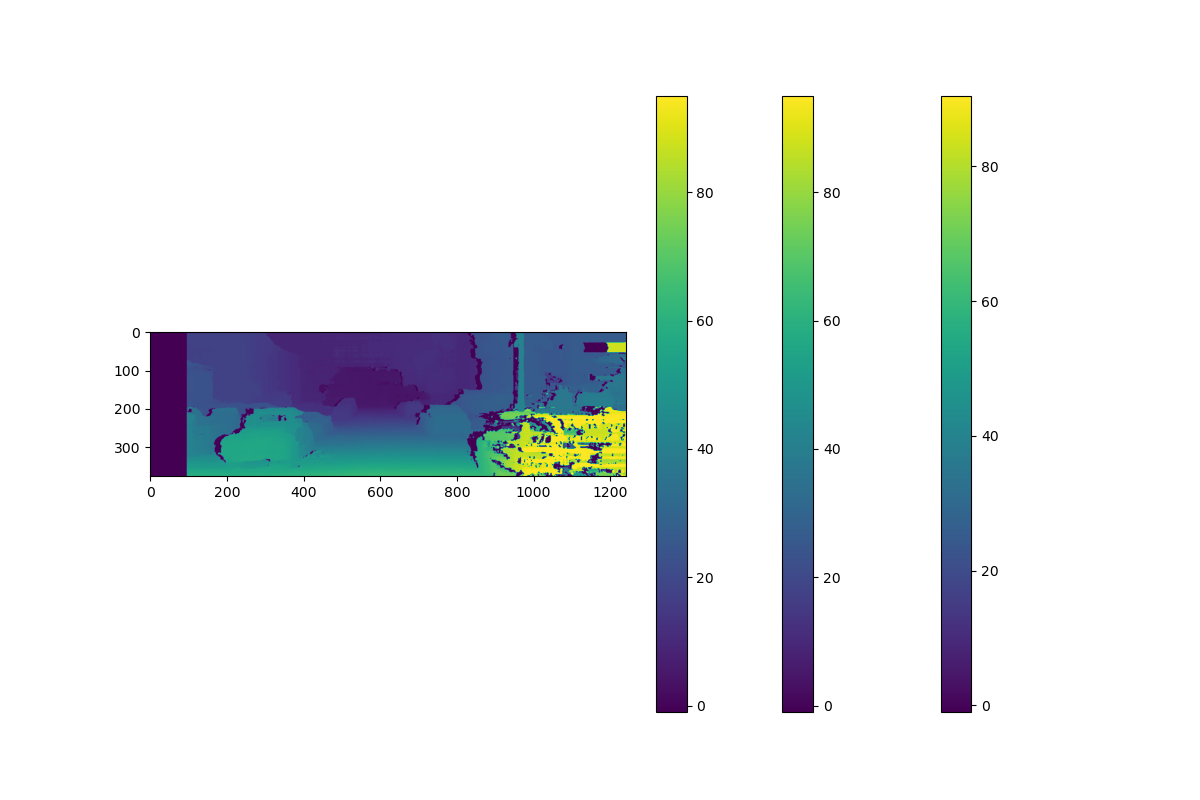


0: 224x640 1 person, 7 cars, 7.5ms
Speed: 0.5ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 640)


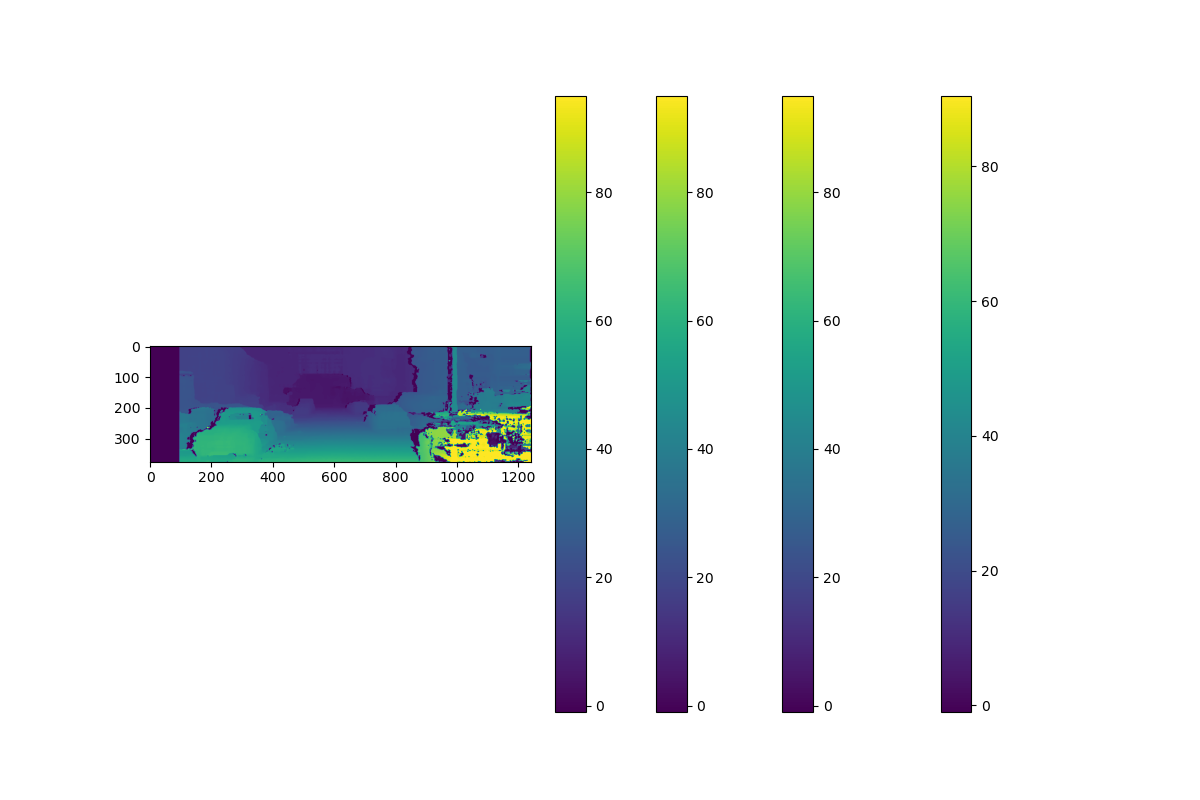


0: 224x640 7 cars, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 640)


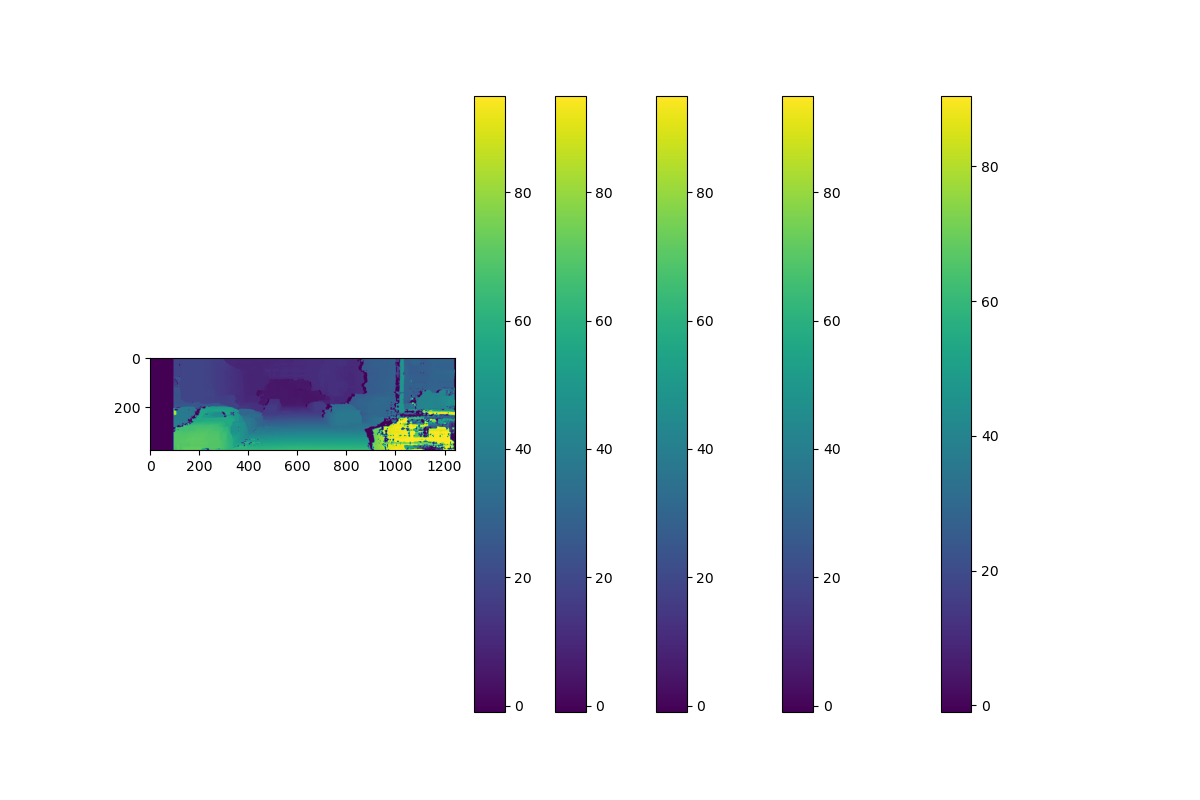


0: 224x640 7 cars, 7.5ms
Speed: 0.5ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 640)


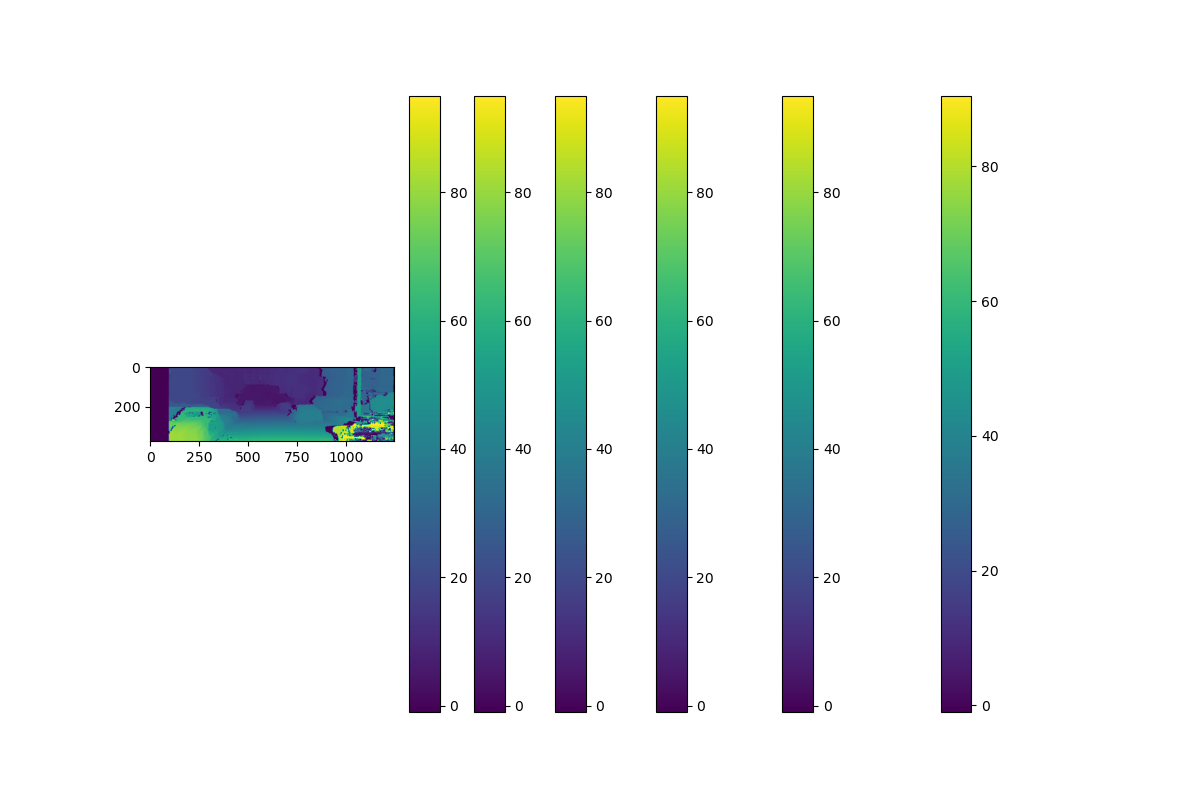


0: 224x640 6 cars, 8.5ms
Speed: 1.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 640)


KeyboardInterrupt: 

In [12]:
path = "videoreferences/2011_09_26_drive_0035_sync"

data_handler = DataLoader(path)

trajectory = odometry(data_handler)